In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import numpy as np
import math
import scipy.stats
import random 
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import collections
from matplotlib.pyplot import figure
import cpnet
from scipy.integrate import odeint

# General functions used throughout the code:

In [2]:
# Method for creating a graph by using edge-list
def graphFromEdgesFile (fname):
    '''Creates a graph from edgelist.'''
    G = nx.read_edgelist (fname, delimiter = '\t')
    print (len (G.nodes ()), len (G.edges ()))
    return G

In [3]:
# Method for making a quick plot of a network
def drawGraph (G, pos = None):
    plt.figure (figsize=(15,15))
    if not pos:
        pos = nx.spring_layout(G) #This layout ensures the plotted graphs do not end up mushy
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos) 
    plt.show()

In [4]:
# Method for plotting sparsity matrices of Adjacency matrix of a graph
def Plot_Sparsity_Matrix(g):
    '''Takes a network g and plots its sparcity matrix.'''
    A = nx.adjacency_matrix(g)
    plt.figure(figsize=(2,2))
    plt.spy(A.todense()) # todense() converts A from sparse matrix type to an array.
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    plt.show()

In [5]:
# Method for creating instance of Stochastic Block Model:
def Create_SBM(N, p, p11, p12, p22):
    ''' Creates an instance of SBM-Graph with 4 blocks.
        N: Number of Nodes
        p: Probability for a node to be in first block-structure (for us, the core)
        p11: Probability of connection within first block-structure
        p12: Probability of connection betweed the two block-structures
        p22: Probability of connection within second block-structure
    '''
    B1 = math.floor(N*p)
    sizes = [B1, N-B1]
    p21 = p12
    probs = [[p11, p12], [p21, p22]]
    G = nx.generators.community.stochastic_block_model(sizes, probs, seed = np.random)
    return(G)

# Block-Structure Diagrams for 3 elementary structures

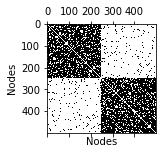

In [6]:
# Modular Structure: p11 > p12=p21 < p22
Com_Struct = Create_SBM(500, 0.5, 0.8, 0.05, 0.8)
Plot_Sparsity_Matrix(Com_Struct)

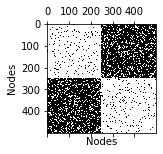

In [7]:
# Bipartite Structure: p11 > p12=p21 > p22
Bip_Struct = Create_SBM(500, 0.5, 0.05, 0.8, 0.05)
Plot_Sparsity_Matrix(Bip_Struct)

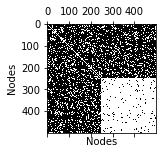

In [8]:
# Core-Periphery Structure: p11 > p12=p21 > p22
CP_Struct = Create_SBM(500, 0.5, 0.8, 0.8, 0.05)
Plot_Sparsity_Matrix(CP_Struct)

# Which centrality measure is most in line with Core-Periphery Structure?

## Selecting SBM variables so that there is considerable overlap between the degrees of Core nodes and the Peripheral nodes

In [9]:
def Degree_Dist_SBM(N, p, p11, p12, p22):
    '''Draw degree distribution of an instance of a specified SBM Network, with core-periphery differentiation
        N: Number of Nodes
        p: Probability for a node to be in first block-structure (for us, the core)
        p11: Probability of connection within first block-structure
        p12: Probability of connection betweed the two block-structures
        p22: Probability of connection within second block-structure
    '''
    G = Create_SBM(N, p, p11, p12, p22)
    Seq = [d for n, d in G.degree()]
    Seq_Core = [Seq[i] for i in range(int(np.floor(N*p)))]
    Combined_Seq = Seq + Seq_Core
    
    Degree_Sequence = sorted(Seq, reverse=True) # Degree Values in descending order.
    Degree_Count = collections.Counter(Degree_Sequence)
    
    Degree_Sequence_of_Core = sorted(Seq_Core, reverse=True)
    Degree_Count_of_Core = collections.Counter(Degree_Sequence_of_Core)
        
    Combined_Degree_Sequence = sorted(Combined_Seq, reverse=True)
    Combined_Degree_Count = collections.Counter(Combined_Degree_Sequence)
    
    deg, cnt = zip(*Degree_Count.items())
    
    deg_core, cnt_core = zip(*Degree_Count_of_Core.items())
    
    comb_deg, comb_cnt = zip(*Combined_Degree_Count.items())
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8.8, 6.6)
    plt.bar(deg, cnt, width=0.80, color="skyblue", edgecolor='black', linewidth=1)
    plt.bar(deg_core, cnt_core, width=0.80, color="lightcoral", edgecolor='black', linewidth=1)


    plt.title("SBM Degree Distribution with Core-Periphery Differentiation:" )
    plt.ylabel("Count")
    plt.xlabel("Degree: Red - Core, Blue - Periphery")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    
    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    
    color_map = []
    for node in G:
        if node < int(np.ceil(N*p)):
            color_map.append('r')
        else: 
            color_map.append('deepskyblue')  
    
    pos = nx.spring_layout(G)
    plt.axis("off")
    
    nx.draw(G, pos, node_color=color_map, node_size=.3, edge_color = 'white')
    
    plt.show()
    

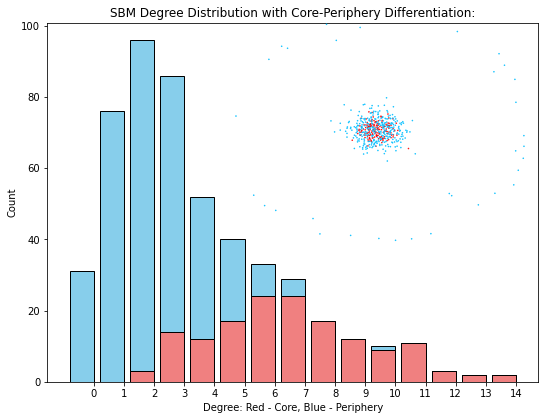

In [10]:
Degree_Dist_SBM(500, 0.3, 0.02, 0.012, 0.002)

## Calculating overlap between different cores perdicted by different centrality measures and the true core:

In [18]:
def Overlap(G, C, N, p):
    '''Calculate overlap value between original core and core recovered by a centrality measure
       for an instance of a specified SBM-Network.
        G: Graph
        C: Dictionary containing centrality values
        N: Number of Nodes
        p: Probability for a node to be in first block-structure (for us, the core)
    '''
    n = math.floor(p*N)
    Sorted_C = list(dict(sorted(C.items(), key=lambda item: item[1],reverse=True)).keys())
    
    Recovered_Core = [Sorted_C[i] for i in range(n)]
    Recovered_Periphery = [Sorted_C[i] for i in range(n, N)]
    
    Recovered_Assignment_Vector = [1 if i in Recovered_Core else 0 for i in range(N)]
    # In the paper this is denoted by yˆM
    
    
    Original_Core = list(G.graph["partition"][0])
    Original_Periphery = list(G.graph["partition"][1])
    
    Original_Assignment_Vector = [1 if i in Original_Core else 0 for i in range(N)]
    # In the paper this is denoted by x

    
    Agreement = sum([1 if Recovered_Assignment_Vector[i] == Original_Assignment_Vector[i] else 0 for i in range(N)])/N
    
    Overlap_val = (Agreement - max(p, 1-p))/(1 - max(p, 1-p))
    return(Overlap_val)
    #return(Agreement)

In [19]:
# Method for calculating Overlap with core periphery and Centrality
def DegC_Overlap_with_CP(N, p, p11, p12, p22, K):
    '''Calculate overlap value between original core and core recovered by a degree centrality
       for K instances of a specified SBM-Network.
    '''
    Overlap_vals = []
    for i in range(K):
        G = Create_SBM(N, p, p11, p12, p22)
        C = nx.degree_centrality(G)
        Overlap_vals.append(Overlap(G, C, N, p))
    print(Overlap_vals)
    return(sum(Overlap_vals)/K)

In [20]:
DegC_avg_overlap_with_CP = DegC_Overlap_with_CP(500, 0.3, 0.02, 0.012, 0.002, 30)
DegC_avg_overlap_with_CP

[0.7333333333333335, 0.6133333333333334, 0.7200000000000002, 0.6933333333333335, 0.7733333333333335, 0.6533333333333334, 0.6800000000000002, 0.5733333333333334, 0.6000000000000001, 0.6266666666666667, 0.6800000000000002, 0.7733333333333335, 0.7466666666666668, 0.7466666666666668, 0.6533333333333334, 0.7733333333333335, 0.7200000000000002, 0.7200000000000002, 0.7200000000000002, 0.7333333333333335, 0.7466666666666668, 0.6266666666666667, 0.7066666666666668, 0.7066666666666668, 0.7466666666666668, 0.6666666666666667, 0.6933333333333335, 0.7066666666666668, 0.6666666666666667, 0.6400000000000001]


0.6946666666666669

In [21]:
# Method for calculating Overlap with core periphery and Centrality
def ClosenessC_Overlap_with_CP(N, p, p11, p12, p22, K):
    '''Calculate overlap value between original core and core recovered by a closeness centrality
       for K instances of a specified SBM-Network.
    '''
    Overlap_vals = []
    for i in range(K):
        G = Create_SBM(N, p, p11, p12, p22)
        C = nx.closeness_centrality(G)
        Overlap_vals.append(Overlap(G, C, N, p))
    print(Overlap_vals)
    return(sum(Overlap_vals)/K)

In [22]:
ClosenessC_avg_overlap_with_CP = ClosenessC_Overlap_with_CP(500, 0.3, 0.02, 0.012, 0.002, 30)
ClosenessC_avg_overlap_with_CP

[0.21333333333333349, 0.37333333333333363, 0.29333333333333356, 0.3466666666666669, 0.3999999999999999, 0.36000000000000026, 0.3466666666666669, 0.36000000000000026, 0.2666666666666669, 0.2533333333333335, 0.37333333333333363, 0.3466666666666669, 0.37333333333333363, 0.36000000000000026, 0.22666666666666682, 0.2800000000000002, 0.29333333333333356, 0.37333333333333363, 0.2800000000000002, 0.36000000000000026, 0.3066666666666669, 0.3066666666666669, 0.2533333333333335, 0.3466666666666669, 0.4666666666666666, 0.3066666666666669, 0.3866666666666666, 0.32000000000000023, 0.3333333333333336, 0.3333333333333336]


0.32800000000000024

In [23]:
# Method for calculating Overlap with core periphery and Centrality
def BetweennessC_Overlap_with_CP(N, p, p11, p12, p22, K):
    '''Calculate overlap value between original core and core recovered by a betweenness centrality
       for K instances of a specified SBM-Network.
    '''
    Overlap_vals = []
    for i in range(K):
        G = Create_SBM(N, p, p11, p12, p22)
        C = nx.betweenness_centrality(G)
        Overlap_vals.append(Overlap(G, C, N, p))
    print(Overlap_vals)
    return(sum(Overlap_vals)/K)

In [24]:
# Note: This takes a lot of time.
BetweennessC_avg_overlap_with_CP = BetweennessC_Overlap_with_CP(500, 0.3, 0.02, 0.012, 0.002, 30)
BetweennessC_avg_overlap_with_CP

[0.6000000000000001, 0.49333333333333335, 0.52, 0.4533333333333333, 0.5466666666666667, 0.6000000000000001, 0.5866666666666668, 0.48, 0.5866666666666668, 0.5066666666666667, 0.5733333333333334, 0.5066666666666667, 0.52, 0.5466666666666667, 0.5333333333333333, 0.6000000000000001, 0.56, 0.52, 0.5333333333333333, 0.5066666666666667, 0.5333333333333333, 0.49333333333333335, 0.56, 0.48, 0.5333333333333333, 0.4666666666666666, 0.5466666666666667, 0.5066666666666667, 0.6000000000000001, 0.5466666666666667]


0.5346666666666666

In [25]:
# Method for calculating Overlap with core periphery and Centrality
def KatzC_Overlap_with_CP(N, p, p11, p12, p22, K):
    '''Calculate overlap value between original core and core recovered by a katz centrality
       for K instances of a specified SBM-Network.
    '''
    Overlap_vals = []
    for i in range(K):
        G = Create_SBM(N, p, p11, p12, p22)
        C = nx.katz_centrality(G, alpha=0.1)
        Overlap_vals.append(Overlap(G, C, N, p))
    print(Overlap_vals)
    return(sum(Overlap_vals)/K)

In [26]:
KatzC_avg_overlap_with_CP = KatzC_Overlap_with_CP(500, 0.3, 0.02, 0.012, 0.002, 30)
KatzC_avg_overlap_with_CP

[0.43999999999999995, 0.49333333333333335, 0.3466666666666669, 0.3866666666666666, 0.3866666666666666, 0.43999999999999995, 0.43999999999999995, 0.48, 0.37333333333333363, 0.4533333333333333, 0.52, 0.49333333333333335, 0.49333333333333335, 0.49333333333333335, 0.49333333333333335, 0.48, 0.48, 0.4666666666666666, 0.52, 0.49333333333333335, 0.4533333333333333, 0.5066666666666667, 0.52, 0.5066666666666667, 0.5866666666666668, 0.42666666666666664, 0.49333333333333335, 0.5066666666666667, 0.52, 0.5066666666666667]


0.4733333333333332

In [27]:
# Method for calculating Overlap with core periphery and Centrality
def PagerankC_Overlap_with_CP(N, p, p11, p12, p22, K):
    '''Calculate overlap value between original core and core recovered by a pagerank centrality
       for K instances of a specified SBM-Network.
    '''
    Overlap_vals = []
    for i in range(K):
        G = Create_SBM(N, p, p11, p12, p22)
        C = nx.pagerank(G)
        Overlap_vals.append(Overlap(G, C, N, p))
    print(Overlap_vals)
    return(sum(Overlap_vals)/K)

In [28]:
PagerankC_avg_overlap_with_CP = PagerankC_Overlap_with_CP(500, 0.3, 0.02, 0.012, 0.002, 30)
PagerankC_avg_overlap_with_CP

[0.6666666666666667, 0.7066666666666668, 0.7333333333333335, 0.7066666666666668, 0.6933333333333335, 0.6666666666666667, 0.6400000000000001, 0.6666666666666667, 0.6800000000000002, 0.6000000000000001, 0.6933333333333335, 0.6533333333333334, 0.6133333333333334, 0.6933333333333335, 0.6533333333333334, 0.6666666666666667, 0.6400000000000001, 0.6133333333333334, 0.6666666666666667, 0.6400000000000001, 0.6133333333333334, 0.5333333333333333, 0.7066666666666668, 0.6400000000000001, 0.6933333333333335, 0.6800000000000002, 0.6800000000000002, 0.6666666666666667, 0.5866666666666668, 0.5866666666666668]


0.6560000000000001

## Method for calculating Overlap with original core periphery and detected core-periphery via BE Algorithm

In [14]:
def Detect_CP_via_BE_Algorithm(G):
    '''Using optimisation algorithms, this function finds the core-periphery pair that maximises the quality 
       function. I have used the inbuilt function of cpnet library.
    '''
    be = cpnet.BE()  # Load the instance of the BE algorithm
    be.detect(G) 
    x = be.get_coreness()  # Get the coreness of nodes
    c = be.get_pair_id()
    return(x, c, be)

In [15]:
# Method for calculating Overlap with original core periphery and core-periphery via BE Algorithm
def BEalg_Overlap_with_CP(N, p, p11, p12, p22, K):
    Overlap_vals = []
    for i in range(K):
        G = Create_SBM(N, p, p11, p12, p22)
        
        x, c, be = Detect_CP_via_BE_Algorithm(G) #Here, we have no use of c.
        Nodes = list(x.keys())
        Labels = list(x.values())
        
        Detected_Core = [Nodes[i] for i in range(len(x)) if Labels[i] == 1]
        Detected_Periphery = [Nodes[i] for i in range(len(x)) if Labels[i] == 0]
        
        Original_Core = list(G.graph["partition"][0])
        Original_Periphery = list(G.graph["partition"][1])
        
        
        
        Overlap_val = len([1 for i in range(N) if (i in Detected_Core and i in Original_Core) 
                 or (i in Detected_Periphery and i in Original_Periphery)])/N
        #Note: There is no need of normalisation in this case.
        #      This is because normalisation is only needed when we give sizes a-priori.
        
        Overlap_vals.append(Overlap_val)
        
    print(Overlap_vals)
    return(sum(Overlap_vals)/K)

In [16]:
# Let us do 30 times. Note: This takes a considerable amount of time.
BEalg_avg_overlap_with_CP = BEalg_Overlap_with_CP(500, 0.3, 0.02, 0.012, 0.002, 30)
BEalg_avg_overlap_with_CP

[0.462, 0.5, 0.312, 0.494, 0.312, 0.296, 0.296, 0.502, 0.3, 0.292, 0.514, 0.454, 0.296, 0.47, 0.296, 0.296, 0.302, 0.296, 0.48, 0.49, 0.498, 0.298, 0.486, 0.296, 0.508, 0.494, 0.296, 0.468, 0.3, 0.456]


0.39199999999999996

## Comparing overlap values of different centrality measures and the BE Algorithm:

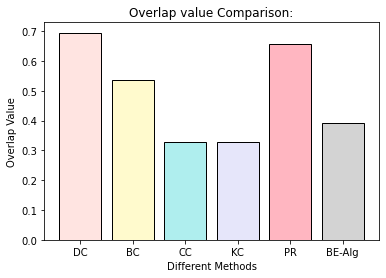

In [29]:
barlist = plt.bar(['DC', 'BC', 'CC', 'KC', 'PR', 'BE-Alg'], [DegC_avg_overlap_with_CP, BetweennessC_avg_overlap_with_CP, 
                   ClosenessC_avg_overlap_with_CP, ClosenessC_avg_overlap_with_CP, PagerankC_avg_overlap_with_CP, 
                  BEalg_avg_overlap_with_CP])

plt.title("Overlap value Comparison:" )
plt.ylabel("Overlap Value")
plt.xlabel("Different Methods")

barlist[0].set_color('mistyrose')
barlist[1].set_color('lemonchiffon')
barlist[2].set_color('paleturquoise')
barlist[3].set_color('lavender')
barlist[4].set_color('lightpink')
barlist[5].set_color('lightgrey')

barlist[0].set_edgecolor('black')
barlist[1].set_edgecolor('black')
barlist[2].set_edgecolor('black')
barlist[3].set_edgecolor('black')
barlist[4].set_edgecolor('black')
barlist[5].set_edgecolor('black')

plt.show()

# Core-Periphery Detection in Empirical Networks

Here, we are basically detecting core-periphery structure in an empirical network.

In [26]:
def erdos_renyi(G):
    ''' Creates an instance of an erdos-renyi random graph with same number of nodes as G.
    '''
    n = G.number_of_nodes()
    p = nx.density(G)
    return nx.fast_gnp_random_graph(n, p)

In [27]:
def Detect_and_Test_CP(G, k):
    ''' Detects core-periphery structure in a network, tests whether the structure is statistically significant
        and then plots the result.
         G: Network in question.
         k: Just an indicator for the kind of plot. 
         (k = 1 if we want the plot of detected core and periphery before the test for statistical significance
         as well.)
    '''
    x, c, be = Detect_CP_via_BE_Algorithm(G)
    
    sig_c, sig_x, significant, p_values = cpnet.qstest(
    c, x, G, be, significance_level=0.01, num_of_thread=4, null_model=erdos_renyi # Default is config_model 
    )
    
    
    if k == 1:
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 7.5))
        ax1.set_title('Detected Core-Periphery Structure')
        ax2.set_title('Statistically Significant Core-Periphery Structure')
    
        labels=nx.get_node_attributes(G, 'value') # This would matter only in the case of polbooks graph
    
        ax1, pos = cpnet.draw(G, c, x, ax1)
        nx.draw_networkx_labels(G, pos=pos, labels = labels)
        ax2, pos = cpnet.draw(G, sig_c, sig_x, ax2, pos=pos)
        
    else:
        fig, ax = plt.subplots(1, 1,figsize=(10, 7.5))
        pos = cpnet.utils.calc_node_pos(G)

        ax.set_title('Statistically Significant Core-Periphery Structure')
    
        labels=nx.get_node_attributes(G, 'value') # This would matter only in the case of polbooks graph
        
        nx.draw_networkx_labels(G, pos=pos, labels = labels)
        ax2, pos = cpnet.draw(G, sig_c, sig_x, ax, pos=pos)

100%|██████████| 300/300 [00:00<00:00, 6582.81it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.02  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds
Name: 
Type: Graph
Number of nodes: 77
Number of edges: 254
Average degree:   6.5974


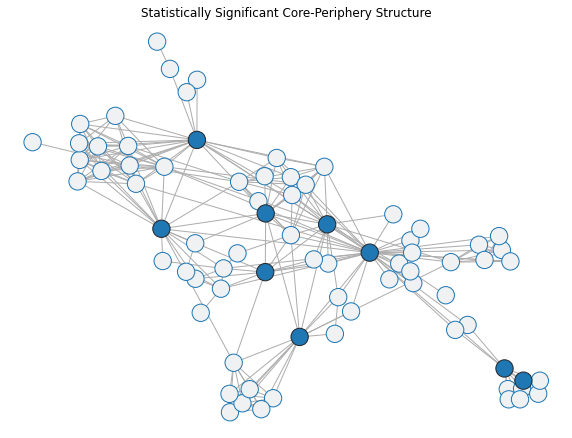

In [30]:
G_Lesmis = nx.read_gml('data/lesmis/lesmis.gml', label = 'id')
Detect_and_Test_CP(G_Lesmis, 0)
print(nx.info(G_Lesmis))

100%|██████████| 300/300 [00:00<00:00, 3662.29it/s]


BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.04  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
Name: 
Type: Graph
Number of nodes: 105
Number of edges: 441
Average degree:   8.4000


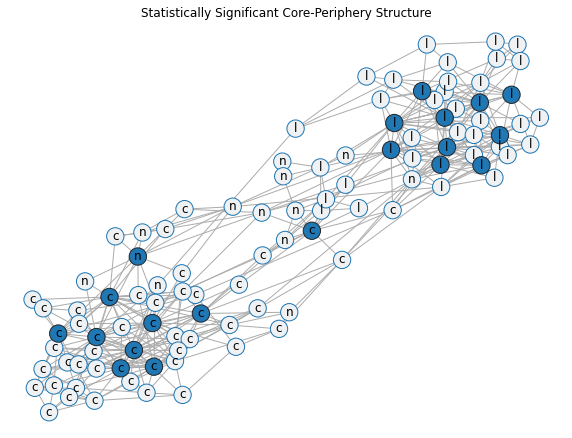

In [33]:
# Graph with data on political books.
G_Pol_Blogs = nx.read_gml('data/polbooks/polbooks.gml')
Detect_and_Test_CP(G_Pol_Blogs, 0)
print(nx.info(G_Pol_Blogs))

100%|██████████| 300/300 [00:00<00:00, 3503.90it/s]

BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.05  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
Name: stochastic_block_model
Type: Graph
Number of nodes: 100
Number of edges: 573
Average degree:  11.4600


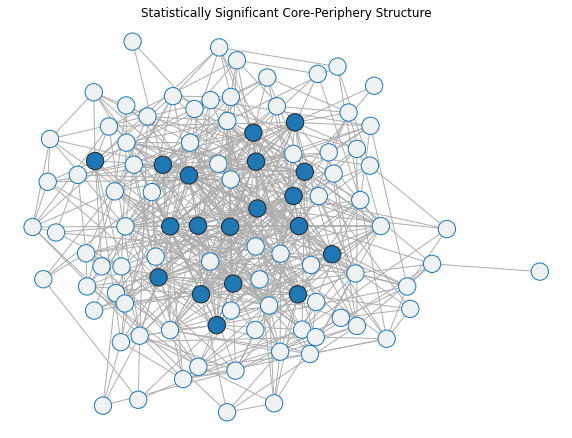

In [34]:
# An instance of SBM model with strong CP-Structure:
G_Strong = Create_SBM(100, 0.3, 0.5, 0.1, 0.05)
Detect_and_Test_CP(G_Strong, 0)
print(nx.info(G_Strong))

100%|██████████| 300/300 [00:00<00:00, 1367.43it/s]


BarnesHut Approximation  took  0.05  seconds
Repulsion forces  took  0.14  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
Name: stochastic_block_model
Type: Graph
Number of nodes: 200
Number of edges: 154
Average degree:   1.5400


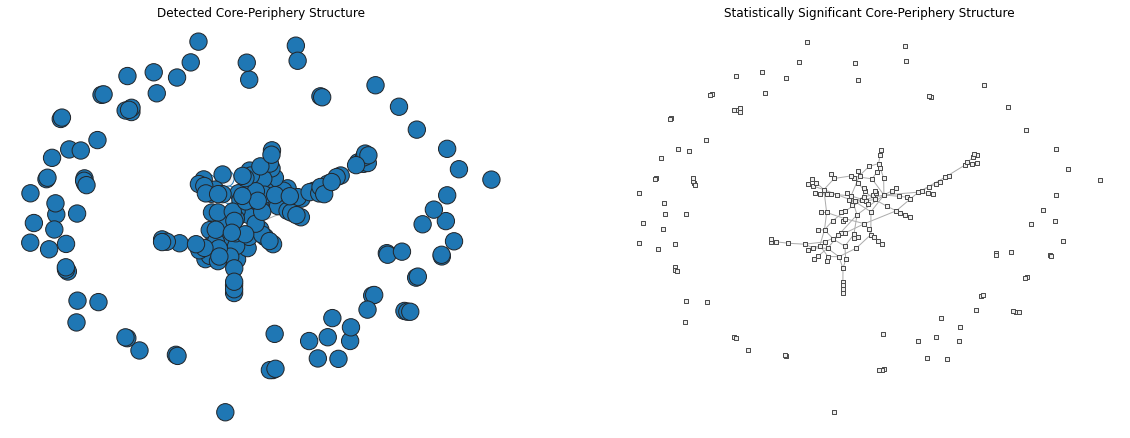

In [35]:
# An instance of SBM Model with sparse CP-Structure:
G_Sparse = Create_SBM(200, 0.3, 0.02, 0.012, 0.002)
Detect_and_Test_CP(G_Sparse, 1)
print(nx.info(G_Sparse))

Clearly, no statistically significant core-periphery structure was discovered in the above network.